In [ ]:
import numpy as np
import warnings
from IPython.display import Audio, display
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy import signal

def envelope_follower(x, fs, attack=0.0001, release=0.005):
    alpha_a = np.exp(-1.0 / (fs * attack))
    alpha_r = np.exp(-1.0 / (fs * release))
    env = np.zeros_like(x)
    prev = 0.0
    for i, sample in enumerate(np.abs(x)):
        if sample > prev:
            coeff = alpha_a
        else:
            coeff = alpha_r
        env[i] = sample * (1 - coeff) + prev * coeff
        prev = env[i]
    return env

def detect_transients(env, threshold=0.05, min_spacing=0.02, fs=44100):
    d_env = np.diff(env, prepend=env[0])
    transients = []
    last_t = -1e9
    for i, d in enumerate(d_env):
        if d > threshold and (i - last_t) > min_spacing * fs:
            transients.append(i)
            last_t = i
    return transients

def smear_transient(slice_buffer, fs, smear_time=0.2, grain_size=0.01, overlap=0.5):
    freq = 440.0
    freq = np.random.uniform(100, 2000)
    slice_len = len(slice_buffer)
    grain_len = int(grain_size * fs)
    smear_len = int(smear_time * fs)
    output = np.zeros(smear_len)
    window = np.hanning(grain_len)
    step_size = int(grain_len * (1 - overlap))
    num_grains = smear_len // step_size
    for g in range(num_grains):
        start_idx = np.random.randint(0, max(1, slice_len - grain_len))
        grain = slice_buffer[start_idx:start_idx+grain_len]
        grain = grain * window[:len(grain)]
        grain *= np.sin(2*np.pi*freq*np.arange(len(grain))/fs)
        pos = g * step_size
        end_pos = pos + len(grain)
        if end_pos > smear_len:
            break
        output[pos:end_pos] += grain
    if np.max(np.abs(output)) > 0:
        output /= np.max(np.abs(output))
    return output

Original length: 325662 samples, Sample rate: 44100 Hz


Detected transients at samples: 143


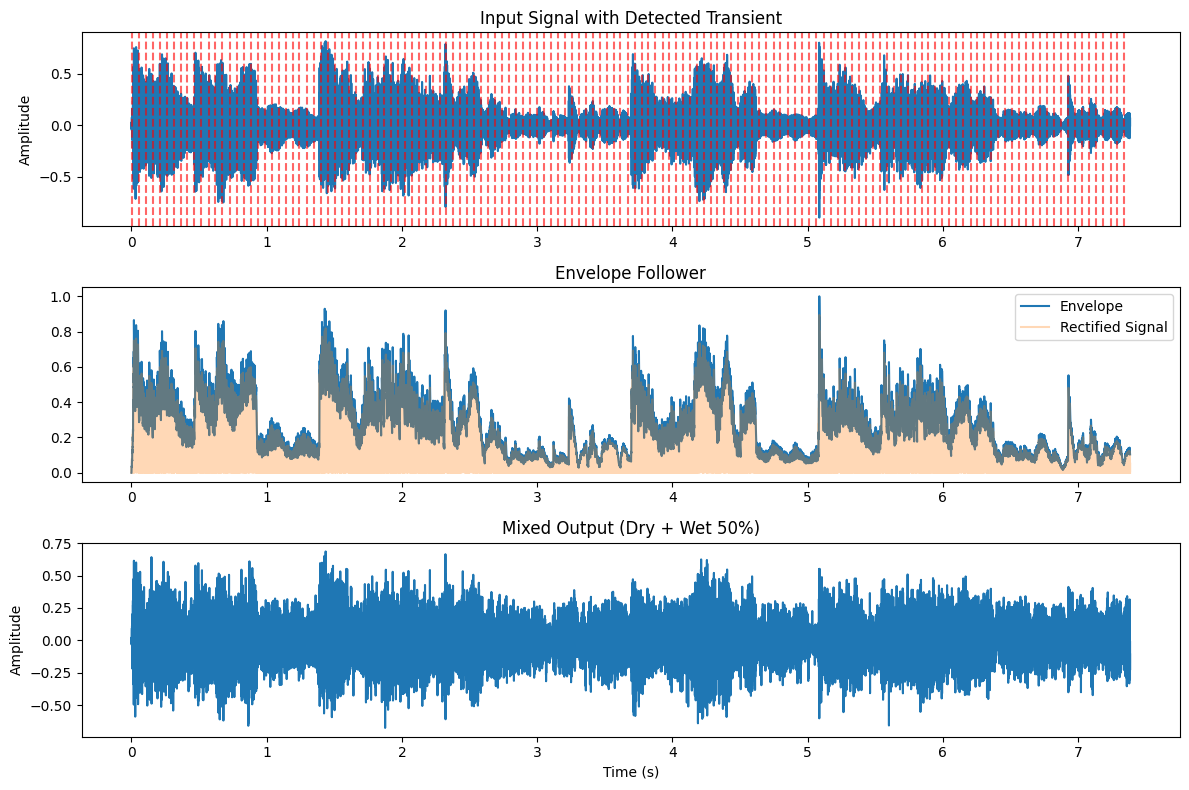

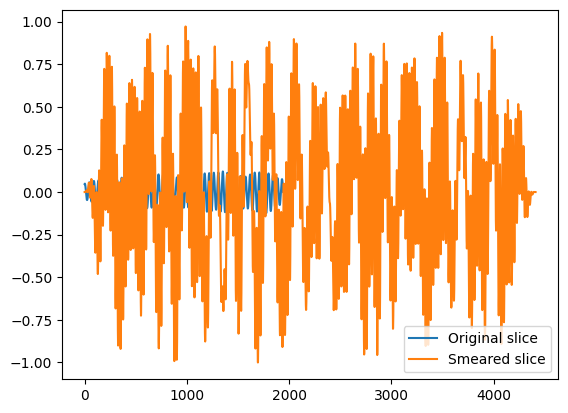

In [103]:
og_len = 5000 # 5 seconds
channels = 2  # Stereo audio

audio_path = "../../resources/audio1.wav"

warnings.simplefilter("ignore", wavfile.WavFileWarning)
sr, y = wavfile.read(audio_path)

# Convert to float32 and normalize
waveform = y.astype(np.float32) / np.max(np.abs(y))  # normalize to [-1,1]

# Convert to mono if stereo
if waveform.ndim > 1:
    waveform = np.mean(waveform, axis=1)

num_samples = len(waveform)
print(f"Original length: {num_samples} samples, Sample rate: {sr} Hz")

# Display audio
display(Audio(waveform, rate=sr))

# Time axis
t = np.arange(num_samples) / sr

# Envelope follower
env = envelope_follower(waveform, sr)
env /= np.max(env)  # normalize envelope

# Detect transients
transients = detect_transients(env, threshold=0.001, min_spacing=0.05, fs=sr)

mixed = np.copy(waveform)

print(f"Detected transients at samples: {len(transients)}")
for idx in transients:
    slice_len = int(0.08 * sr)
    slice_buffer = waveform[idx:idx+slice_len]
    smeared = smear_transient(slice_buffer, sr, smear_time=0.1, grain_size=0.01, overlap=0.7)

    smear_len = min(len(smeared), len(mixed) - idx)
    mixed[idx:idx+smear_len] = 0.7 * waveform[idx:idx+smear_len] + 0.3 * smeared[:smear_len]

display(Audio(mixed, rate=sr))

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.title("Input Signal with Detected Transient")
plt.plot(t, waveform)
for tr in transients:
    plt.axvline(tr/sr, color='r', linestyle='--', alpha=0.6)
plt.ylabel("Amplitude")

plt.subplot(3, 1, 2)
plt.title("Envelope Follower")
plt.plot(t, env, label="Envelope")
plt.plot(t, np.abs(waveform), alpha=0.3, label="Rectified Signal")
plt.legend()

plt.subplot(3, 1, 3)
plt.title("Mixed Output (Dry + Wet 50%)")
plt.plot(t, mixed)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

plt.figure()
plt.plot(slice_buffer, label="Original slice")
plt.plot(smeared, label="Smeared slice")
plt.legend()
plt.show()
